<a href="https://colab.research.google.com/github/Mo0nro2e/DNN_stock_forcast/blob/master/stock_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (14, 10)
mpl.rcParams['axes.grid'] = False

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/Mo0nro2e/DNN_stock_forcast/master/bgr.us.txt \
    -O /tmp/bgr.txt

!wget --no-check-certificate \
     https://raw.githubusercontent.com/Mo0nro2e/DNN_stock_forcast/master/jci.us.txt \
    -O /tmp/jci.txt

!wget --no-check-certificate \
  https://raw.githubusercontent.com/Mo0nro2e/DNN_stock_forcast/master/prk.us.txt \
  -O /tmp/prk.txt

--2020-08-26 06:52:16--  https://raw.githubusercontent.com/Mo0nro2e/DNN_stock_forcast/master/bgr.us.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 154740 (151K) [text/plain]
Saving to: ‘/tmp/bgr.txt’

/tmp/bgr.txt        100%[===================>] 151.11K  --.-KB/s    in 0.04s   

2020-08-26 06:52:17 (3.56 MB/s) - ‘/tmp/bgr.txt’ saved [154740/154740]

--2020-08-26 06:52:17--  https://raw.githubusercontent.com/Mo0nro2e/DNN_stock_forcast/master/jci.us.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 373164 (364K) [text/plain]
Saving t

In [3]:
bgr = "/tmp/bgr.txt"
jci = "/tmp/jci.txt"
prk = "/tmp/prk.txt"
df_bgr = pd.read_csv(bgr, engine='python', header=0, sep=',')
df_jci = pd.read_csv(jci, engine='python', header=0, sep=',')
df_prk = pd.read_csv(prk, engine='python', header=0, sep=',')

In [4]:
df_jci.head()

,Date,Open,High,Low,Close,Volume,OpenInt
0,1987-12-30,1.7421,1.7935,1.7421,1.7935,210578,0
1,1987-12-31,1.7808,1.7808,1.7595,1.7808,203519,0
2,1988-01-04,1.7765,1.8236,1.7765,1.8022,252931,0
3,1988-01-05,1.8236,1.8836,1.8236,1.8449,531741,0
4,1988-01-06,1.8962,1.8962,1.8621,1.8836,826439,0


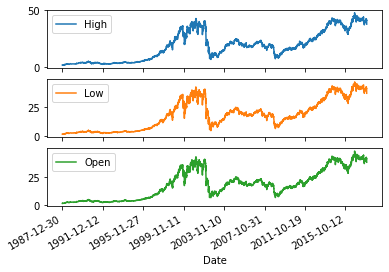

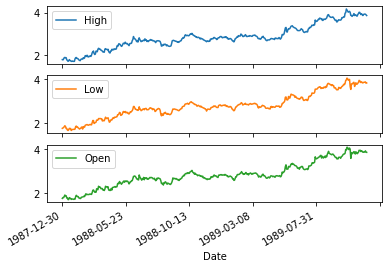

In [5]:
date_time = df_jci['Date']
df_jci = df_jci.drop(['OpenInt','Date'], axis=1)
plot_cols = ['High', 'Low', 'Open']
plot_features = df_jci[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df_jci[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)

In [6]:
df_jci.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Open,7527.0,1.811261e+01,1.262045e+01,1.6864,4.610100e+00,17.686,2.641300e+01,4.767300e+01
High,7527.0,1.832413e+01,1.273799e+01,1.7124,4.644450e+00,17.895,2.683250e+01,4.781000e+01
Low,7527.0,1.789395e+01,1.249300e+01,1.6438,4.584700e+00,17.489,2.586750e+01,4.615100e+01
Close,7527.0,1.811776e+01,1.261700e+01,1.6864,4.610100e+00,17.713,2.641300e+01,4.774100e+01
Volume,7527.0,7.993143e+06,1.364385e+07,0.0000,1.438476e+06,4940807.000,1.035742e+07,3.278264e+08


In [12]:
column_indices = {name: i for i, name in enumerate(df_jci.columns)}

n = len(df_jci)
train_df = df_jci[0:int(n*0.7)]
val_df = df_jci[int(n*0.7):int(n*0.9)]
test_df = df_jci[int(n*0.9):]

num_features = df_jci.shape[1]

In [13]:
train_df.head()

,Open,High,Low,Close,Volume
0,1.7421,1.7935,1.7421,1.7935,210578
1,1.7808,1.7808,1.7595,1.7808,203519
2,1.7765,1.8236,1.7765,1.8022,252931
3,1.8236,1.8836,1.8236,1.8449,531741
4,1.8962,1.8962,1.8621,1.8836,826439


In [14]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

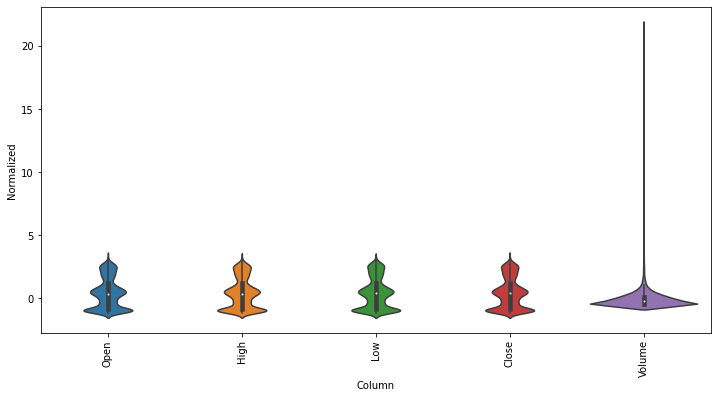

In [17]:
df_std = (df_jci - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df_jci.keys(), rotation=90)

In [18]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [21]:
w1 = WindowGenerator(input_width=29, label_width=1, shift=1,
                     label_columns=['Open'])

w1

Total window size: 30
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28]
Label indices: [29]
Label column name(s): ['Open']

In [22]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [24]:
# Stack three slices, the length of the total window:
example_window = tf.stack([np.array(train_df[:w1.total_window_size]),
                           np.array(train_df[100:100+w1.total_window_size]),
                           np.array(train_df[200:200+w1.total_window_size])])


example_inputs, example_labels = w1.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 30, 5)
Inputs shape: (3, 29, 5)
labels shape: (3, 1, 1)


In [25]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float64)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [26]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [28]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [30]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['Open'])
single_step_window

baseline = Baseline(label_index=column_indices['Open'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

48/48 [==============================] - 0s 3ms/step - loss: 9.9910e-04 - mean_absolute_error: 0.0235


In [31]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['Open'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['Open']

In [32]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', baseline(single_step_window.example[0]).shape)

Input shape: (32, 1, 5)
Output shape: (32, 1, 1)


In [35]:
def plot(self, model=None, plot_col='Open', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(3, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Date')

WindowGenerator.plot = plot

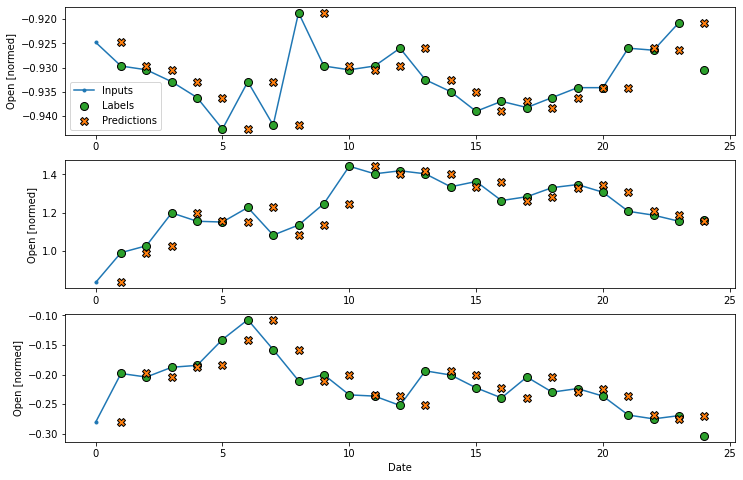

In [36]:
wide_window.plot(baseline)